# Importing Dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

import math
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Loading Data

In [2]:
df = pd.read_csv('AAPL.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,73449600


# Data Preprocessing

In [4]:
data = df['Close'].loc[df['Date']>'2010-01-01'].reset_index(drop=True)

In [5]:
data.head()

0    7.643214
1    7.656429
2    7.534643
3    7.520714
4    7.570714
Name: Close, dtype: float64

In [6]:
data.tail()

3459    173.75000
3460    172.39999
3461    173.66000
3462    174.91000
3463    177.49001
Name: Close, dtype: float64

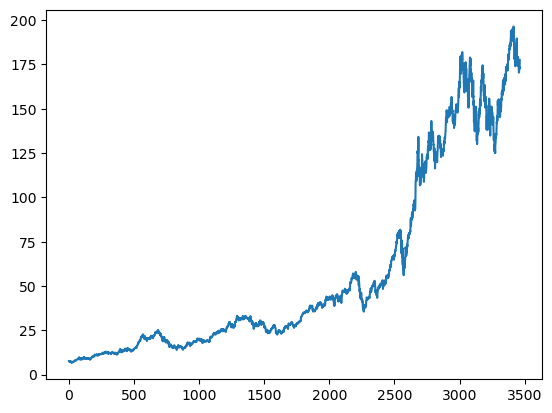

In [7]:
plt.plot(data)

In [8]:
stdscaler = StandardScaler()

In [9]:
data = stdscaler.fit_transform(np.array(data).reshape(-1,1))

In [10]:
training_size = int(0.8*len(data[:, 0]))
test_size = len(data[:, 0]) - training_size

In [11]:
training_size, test_size

(2771, 693)

In [12]:
train_data = data[0: training_size]
test_data = data[training_size: len(data[:, 0])]

In [13]:
def XySplit(data, time_window = 20):
    X = []
    y = []
    for i in range(0, len(data[:, 0])-time_window-1):
        X.append(data[i:i+time_window, 0])
        y.append(data[i+time_window, 0])
    return np.array(X), np.array(y)

In [14]:
time_window = 100

In [15]:
X_train, y_train = XySplit(train_data, time_window)
X_test, y_test = XySplit(test_data, time_window)

In [16]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2670, 100), (2670,), (592, 100), (592,))

In [17]:
X_train =X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model

In [18]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

In [19]:
model.compile(loss ='mean_squared_error', optimizer = Adam(learning_rate = 0.0001))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

# Training

In [21]:
def trainer(epochs, verbose):
    model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=epochs, batch_size=64, verbose=verbose)

In [22]:
def report():
    train_predict=stdscaler.inverse_transform(model.predict(X_train))
    test_predict=stdscaler.inverse_transform(model.predict(X_test))
    
    print(f'\n\nTrain RMSE Loss: {math.sqrt(mean_squared_error(y_train,train_predict))}')
    print(f'\n\nTest RMSE Loss: {math.sqrt(mean_squared_error(y_test,test_predict))}')
    print(f'\n\nTest MAPE Loss: {mean_absolute_percentage_error(y_test, test_predict)}\n\n')
    
    
    trainPredictPlot = np.empty_like(data)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_window:len(train_predict)+time_window, :] = train_predict

    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_window*2)+1:len(data)-1, :] = test_predict
    
    plt.plot(stdscaler.inverse_transform(data), color = 'black')
    plt.plot(trainPredictPlot, color = 'blue')
    plt.plot(testPredictPlot, color = 'red')
    plt.legend(['Actual Data', 'Train Predict', 'Test Predict'])
    plt.title('Actual vs Predicted values')
    plt.figure(figsize = (19, 10))
    plt.show()
    
    plt.plot(stdscaler.inverse_transform(y_test.reshape(-1,1)), color = 'black')
    plt.plot(test_predict, color = 'red')
    plt.legend(['Actual Data', 'Test Predict'])
    plt.title('Actual Testing vs Predicted Testing values')
    plt.figure(figsize = (19, 10))
    plt.show()

In [26]:
trainer(100, 1)

Epoch 1/100
42/42 [==============================] - 9s 226ms/step - loss: 0.0086 - val_loss: 0.0309
Epoch 2/100
42/42 [==============================] - 11s 256ms/step - loss: 0.0098 - val_loss: 0.0701
Epoch 3/100
42/42 [==============================] - 10s 248ms/step - loss: 0.0092 - val_loss: 0.0301
Epoch 4/100
42/42 [==============================] - 10s 247ms/step - loss: 0.0102 - val_loss: 0.0263
Epoch 5/100
42/42 [==============================] - 10s 248ms/step - loss: 0.0090 - val_loss: 0.0377
Epoch 6/100
42/42 [==============================] - 10s 246ms/step - loss: 0.0100 - val_loss: 0.0299
Epoch 7/100
42/42 [==============================] - 10s 246ms/step - loss: 0.0085 - val_loss: 0.0289
Epoch 8/100
42/42 [==============================] - 10s 250ms/step - loss: 0.0089 - val_loss: 0.0508
Epoch 9/100
42/42 [==============================] - 10s 248ms/step - loss: 0.0090 - val_loss: 0.0304
Epoch 10/100
42/42 [==============================] - 10s 245ms/step - loss: 0.0102

# Result Analysis

19/19 [==============================] - 1s 29ms/step


Train RMSE Loss: 43.02309913517294


Test RMSE Loss: 149.75610540197206


Test MAPE Loss: 80.90190724861297




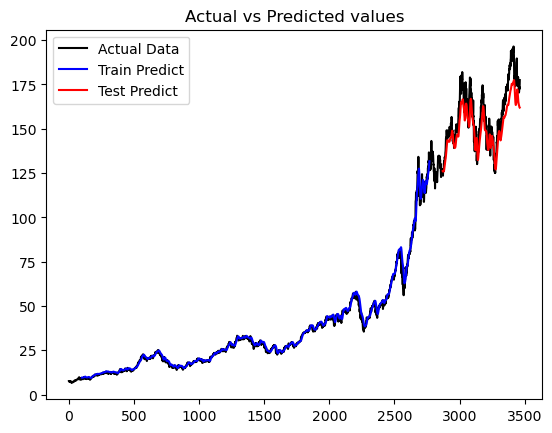

<Figure size 1900x1000 with 0 Axes>

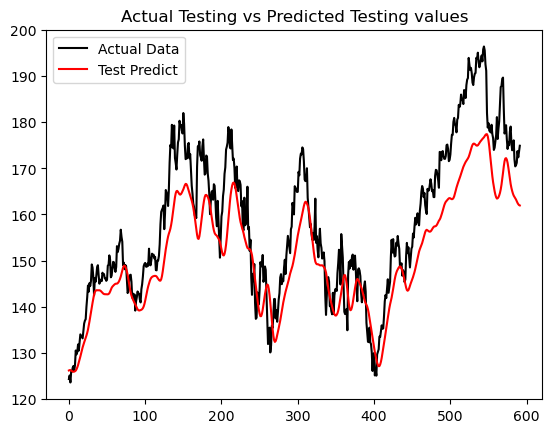

<Figure size 1900x1000 with 0 Axes>

In [27]:
report()

In [28]:
model.save('AAPLmodel.h5')

C:\Users\KIIT\.conda\envs\dl\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Tested Models

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

lr = 0.001

train loss: 42.53407718394477

test loss: 147.45663506622907

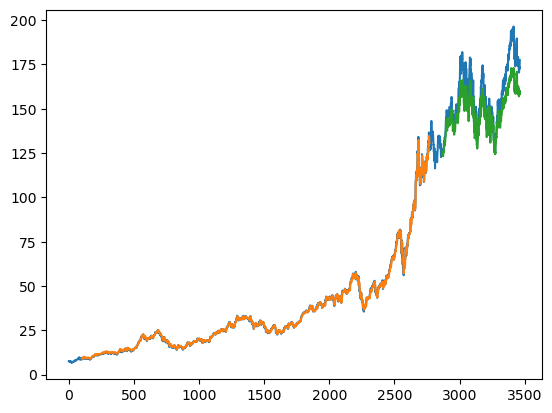

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.25))
model.add(LSTM(25,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(25))
model.add(Dropout(0.25))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.52218436865986

test_loss: 140.759728056867

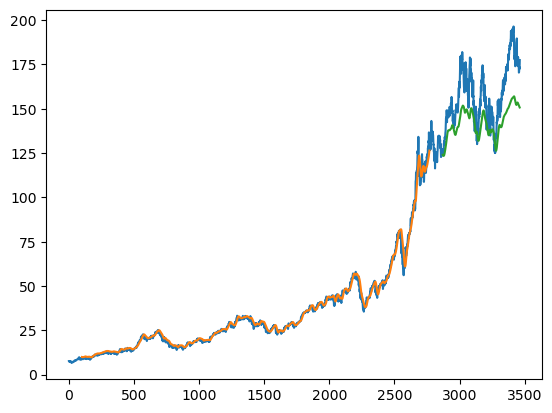

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.25))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(50))
model.add(Dropout(0.25))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.357468163747015

test_loss: 150.1653993070135

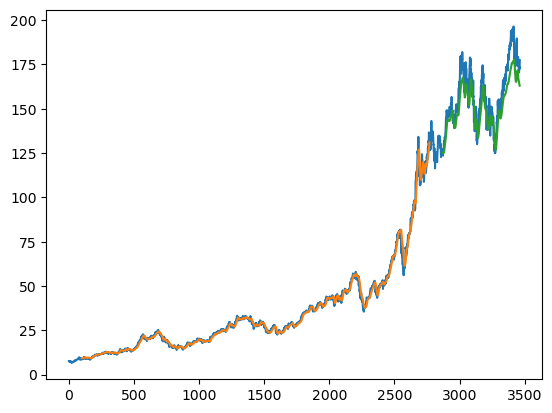

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_window,1)))
model.add(Dropout(0.5))
model.add(LSTM(50,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1))

lr = 0.0001

train_loss: 42.74031398132778

test_loss: 150.3392457216271

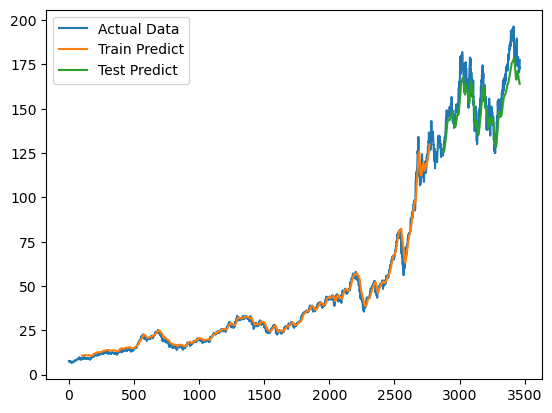

In [25]:
from tensorflow.keras.models import load_model

In [29]:
model = load_model('StockModel4.h5')

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 dropout_6 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_7 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [23]:
epochs_list = [25, 50]

epochs: 25
19/19 [==============================] - 1s 41ms/step


Train RMSE Loss: 42.936617368862144


Test RMSE Loss: 145.95711319986503


Test MAPE Loss: 79.28149626026303




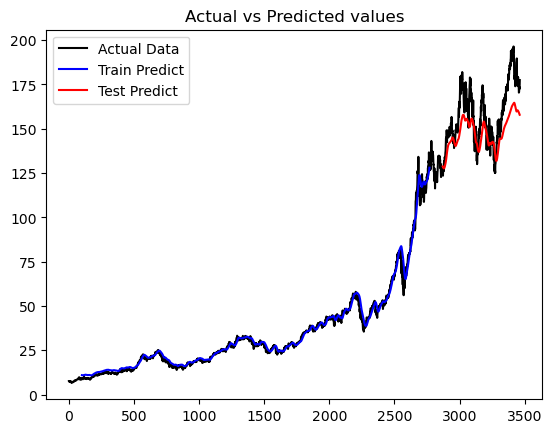

<Figure size 1900x1000 with 0 Axes>

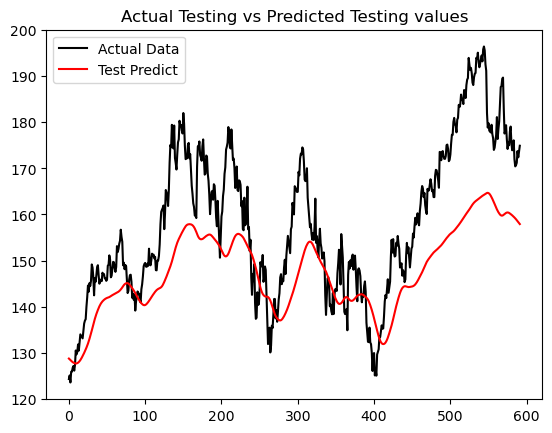

<Figure size 1900x1000 with 0 Axes>

epochs: 50
19/19 [==============================] - 1s 41ms/step


Train RMSE Loss: 42.1614549779608


Test RMSE Loss: 147.97395590445876


Test MAPE Loss: 79.98094562720274




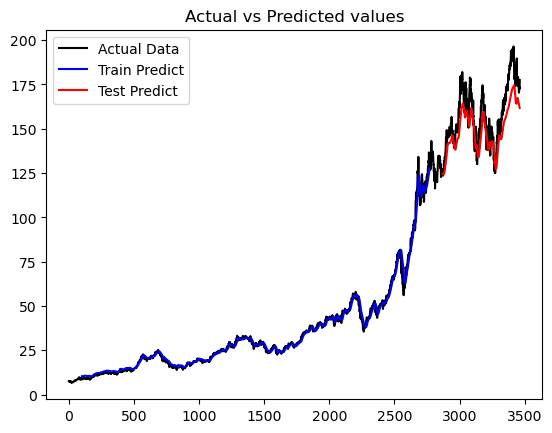

<Figure size 1900x1000 with 0 Axes>

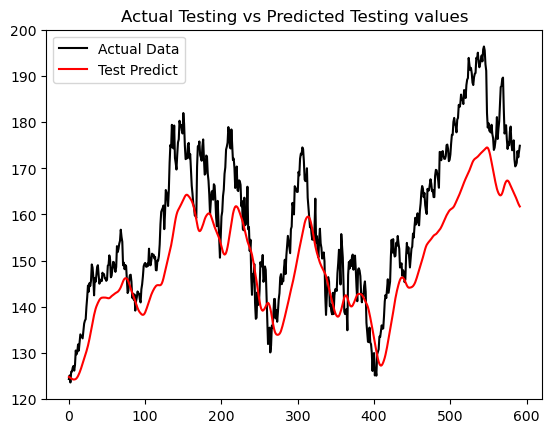

<Figure size 1900x1000 with 0 Axes>

In [24]:
for epochs in epochs_list:
    print(f'epochs: {epochs}')
    trainer(epochs, 0)
    report()

In [3]:
loaded_model = load_model("AAPLmodel.h5")

In [4]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

In [5]:
#R4Z0Rx